In [1]:
!pip install --upgrade pip

Defaulting to user installation because normal site-packages is not writeable


In [2]:
!pip install opencv-contrib-python-headless

Defaulting to user installation because normal site-packages is not writeable
  Using cached opencv_contrib_python_headless-4.7.0.72-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (55.3 MB)


In [3]:
!pip install fastparquet

Defaulting to user installation because normal site-packages is not writeable
  Using cached fastparquet-2023.4.0-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.6 MB)
  Using cached cramjam-2.6.2-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (2.0 MB)
  Using cached fsspec-2023.5.0-py3-none-any.whl (160 kB)


In [4]:
import cv2
import numpy as np
import os, sys
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics import adjusted_rand_score, confusion_matrix,classification_report

module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)
from lib.graphUtils import (
    show_pie,
    show_lines,
    show_pca_variance_graph,
    show_pca_correlation_graph,
    show_scatter_graph,
    show_cols_boxplots_by_col,
    view_clustered_heatmap,
)
import plotly.io as pio

import matplotlib.pyplot as plt
import seaborn as sns

pio.renderers.default = "iframe"

In [5]:
df = pd.read_parquet("../../etude_classification_texte/working/cleaned.parquet")

In [6]:
df.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications,category0,cleaned_product_name,cleaned_description
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v...",home furnishing,polyest multicolor abstract eyelet door curtain,polyest multicolor abstract eyelet door curtai...
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa...",baby care,cotton bath towel,cotton bath towel bath towel yellow blue bath ...
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",...",baby care,cotton terri face towel,cotton terri face towel small cotton terri fac...
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v...",home furnishing,cotton king doubl bedsheet,cotton king doubl bedsheet royal bedsheet perf...
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa...",home furnishing,cotton floral king doubl bedsheet,cotton floral king doubl bedsheet cotton cotto...


# Lecture et détection des features de tous les produits

In [7]:
sift = cv2.SIFT_create()

In [8]:
all_descriptors = []
nb_done = 0
image_keypoints = {}
image_descriptors = {}

for uniq_id in df["uniq_id"]:
    img = cv2.imread(f"../../etude_classification_texte/assets/Flipkart/Images/{uniq_id}.jpg", cv2.IMREAD_GRAYSCALE)
    img = cv2.equalizeHist(img)
    keypoints, descriptors = sift.detectAndCompute(img, None)
    if descriptors is None:
        print(f"pb avec fichier {uniq_id}.jpg")
        continue
    image_keypoints[uniq_id] = keypoints
    image_descriptors[uniq_id] = descriptors
    
    for descriptor in descriptors:
        all_descriptors.append(descriptor)
    nb_done += 1
    if nb_done % 100 == 0:
        print(f"Done {nb_done}")

Done 100
Done 200
Done 300
Done 400
Done 500
Done 600
Done 700
Done 800
Done 900
Done 1000


In [9]:
len(all_descriptors)

9051347

In [10]:
all_unique_descriptors = np.unique(all_descriptors, axis=0)

In [11]:
all_unique_descriptors.shape

(9005630, 128)

## Visualisation des features

In [12]:
uniq_id0 = df.iloc[510]["uniq_id"]
print(len(image_keypoints[uniq_id0]))

1762


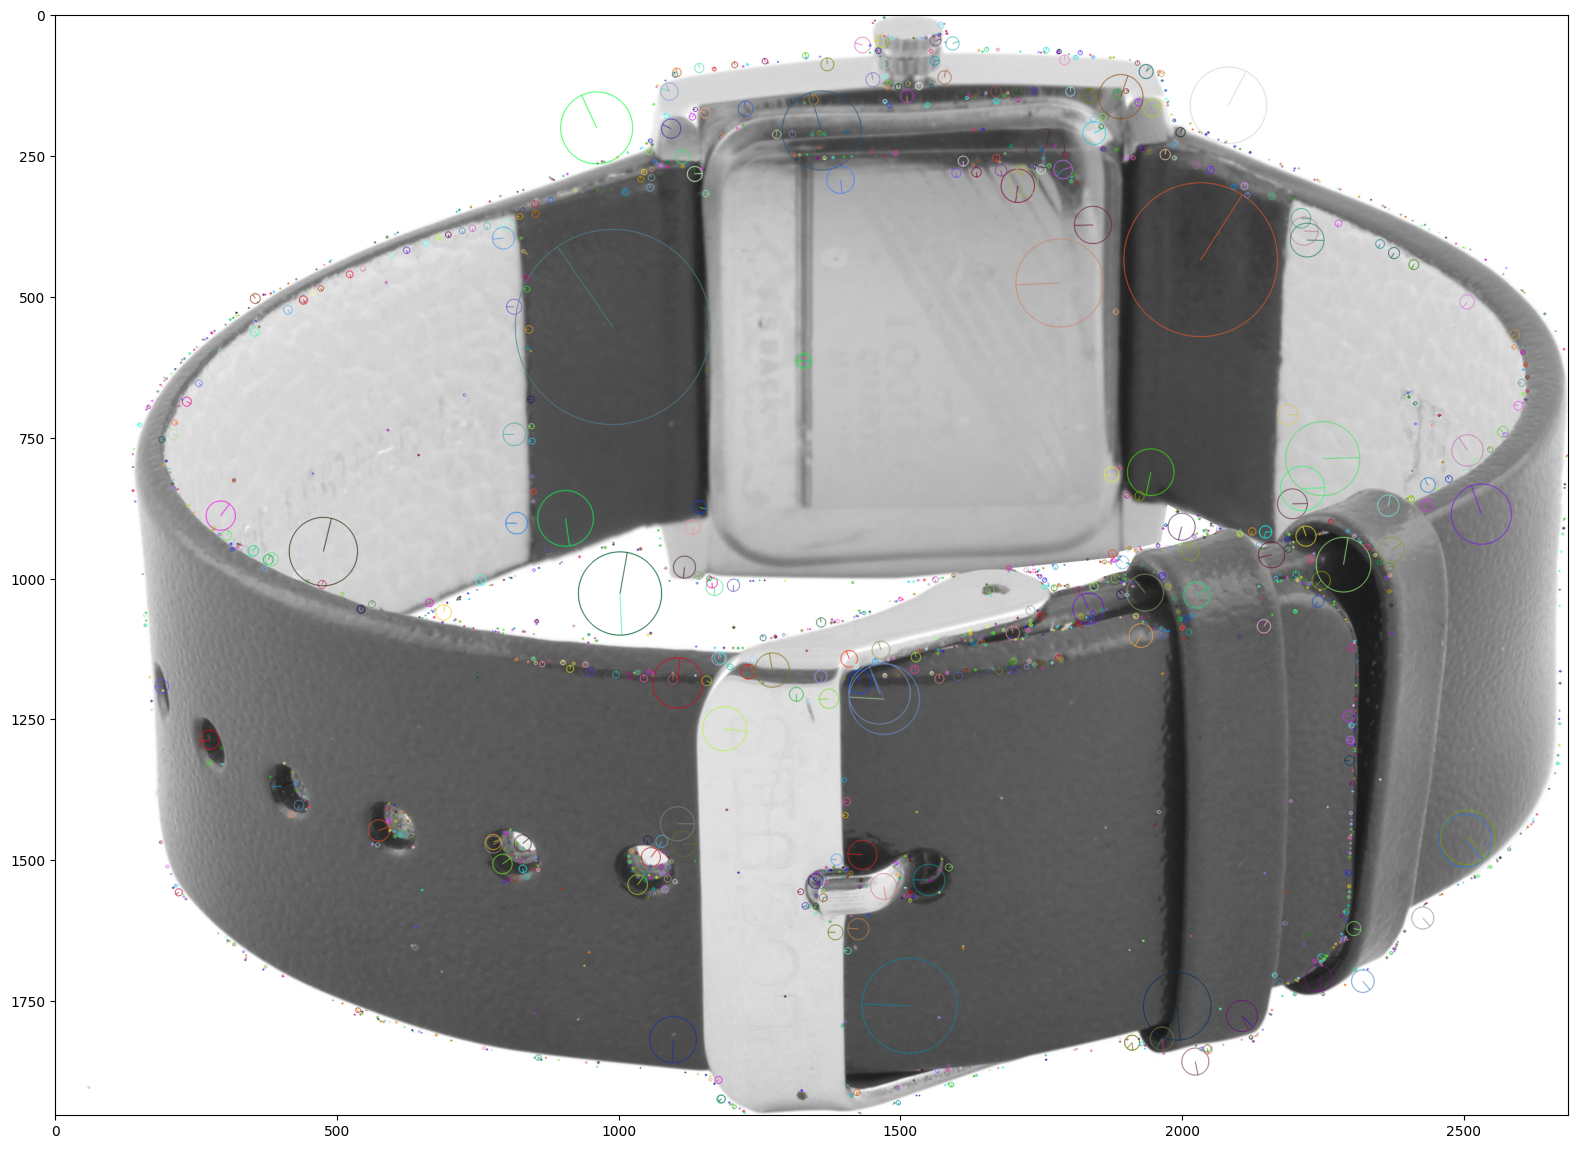

In [13]:
img = cv2.imread(f"../../etude_classification_texte/assets/Flipkart/Images/{uniq_id0}.jpg", cv2.IMREAD_GRAYSCALE)
plt.figure(figsize=(img.shape[0]/100,img.shape[1]/100))

output_image=cv2.drawKeypoints(img,image_keypoints[uniq_id0],0,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(output_image)
plt.show()

# Clustering KMeans des descripteurs

In [14]:
uniq_id0 = df.iloc[0]["uniq_id"]
image_descriptors[uniq_id0].shape

(98204, 128)

In [15]:
min_descriptors = len(image_descriptors[uniq_id0])
max_descriptors = len(image_descriptors[uniq_id0])
for uniq_id in image_descriptors.keys():
    min_descriptors = min(min_descriptors, len(image_descriptors[uniq_id]))
    max_descriptors = max(max_descriptors, len(image_descriptors[uniq_id]))
print(min_descriptors, max_descriptors)

114 433180


Chaque image a un nombre de descripteurs différents (entre 114 et 433180) qui sont des vecteurs de dimension 128. Il y a en tout 9005630 differents descripteurs d'images. 

Il est donc impossible de travailler directement sur les descripteurs extraits des differentes images.

Nous allons plutot tenter de regrouper les features dans des Bags of Words. Pour cela:
- nous effectuons un clustering sur les descripteurs : comme nous savons que nous avons 7 catégories au départ, nous allons faire un clustering avec 700 clusters
- nous allons ensuite réaliser un histogramme pour chaque cluster trouvé: pour chaque image (article), nous allons compter le nombre de descripteurs dans chacun des clusters trouvés. Comme nous avons un nombre de clusters différent pour chaque image, nous normalisons en additionnant l'inverse du nombre total de descripteur dans l'image.
- nous pouvons alors travailler sur les colonnes des clusters trouvés et leurs valeurs (PCA, tSNE)

In [16]:
k = 7 * 100

In [17]:
len(all_descriptors[0])

128

In [18]:
batch_size = np.size(os.listdir("../../etude_classification_texte/assets/Flipkart/Images"))*3
kmeans = MiniBatchKMeans(n_clusters=k, batch_size=batch_size, verbose=0, n_init="auto").fit(all_descriptors)

In [19]:
kmeans.predict([all_descriptors[1]])

array([293], dtype=int32)

Ajoutons au dataframe les colonnes correspondant aux clusters trouvés à partir des descripteurs des images

In [20]:
drop_cols = []
for c in df.columns:
    if c.startswith("histo_km_"):
        drop_cols.append(c)
        
if len(drop_cols)>0:
    df.drop(columns=drop_cols, inplace=True)
    
for i in range(0,k):
    df = pd.concat([df, pd.Series([0 for j in range(0,k)], name=f"histo_km_{i}")], axis=1)

In [21]:
df.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,...,histo_km_690,histo_km_691,histo_km_692,histo_km_693,histo_km_694,histo_km_695,histo_km_696,histo_km_697,histo_km_698,histo_km_699
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
nb_done = 0
for uniq_id in df["uniq_id"]:
    r = {}
    for i in range(0,k): r[f"histo_km_{i}"] = 0.0
        
    k_labels_idx = kmeans.predict(np.array(image_descriptors[uniq_id], dtype=float))
    for i in range(0, len(image_descriptors[uniq_id])):
        k_label_idx = k_labels_idx[i]
        r[f"histo_km_{k_label_idx}"] += 1/len(image_descriptors[uniq_id])

    for i in range(0,k):
        df.loc[df["uniq_id"]==uniq_id, f"histo_km_{i}"] = r[f"histo_km_{i}"]
    nb_done += 1
    if nb_done % 50 == 0:
        print(f"Done {nb_done} rows")

Done 50 rows
Done 100 rows
Done 150 rows
Done 200 rows
Done 250 rows
Done 300 rows
Done 350 rows
Done 400 rows
Done 450 rows
Done 500 rows
Done 550 rows
Done 600 rows
Done 650 rows
Done 700 rows
Done 750 rows
Done 800 rows
Done 850 rows
Done 900 rows
Done 950 rows
Done 1000 rows
Done 1050 rows


In [23]:
df.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,...,histo_km_690,histo_km_691,histo_km_692,histo_km_693,histo_km_694,histo_km_695,histo_km_696,histo_km_697,histo_km_698,histo_km_699
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,...,0.000855,0.000652,0.001018,0.000611,0.003584,0.000010,0.000010,0.011608,0.000214,0.002688
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,...,0.000755,0.002057,0.001196,0.000986,0.000441,0.000126,0.000105,0.000168,0.001364,0.001259
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,...,0.000225,0.000112,0.002023,0.001124,0.000225,0.001124,0.000450,0.002473,0.002136,0.000450
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,...,0.001106,0.001531,0.000766,0.000936,0.000425,0.000510,0.000340,0.003233,0.002722,0.000340
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,...,0.002111,0.001211,0.001004,0.000381,0.005607,0.000450,0.000035,0.000104,0.000658,0.002319


In [24]:
df.to_parquet("sift_bow.parquet")

In [25]:
df = pd.read_parquet("sift_bow.parquet")

In [26]:
df.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,...,histo_km_690,histo_km_691,histo_km_692,histo_km_693,histo_km_694,histo_km_695,histo_km_696,histo_km_697,histo_km_698,histo_km_699
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,...,0.000855,0.000652,0.001018,0.000611,0.003584,0.000010,0.000010,0.011608,0.000214,0.002688
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,...,0.000755,0.002057,0.001196,0.000986,0.000441,0.000126,0.000105,0.000168,0.001364,0.001259
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,...,0.000225,0.000112,0.002023,0.001124,0.000225,0.001124,0.000450,0.002473,0.002136,0.000450
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,...,0.001106,0.001531,0.000766,0.000936,0.000425,0.000510,0.000340,0.003233,0.002722,0.000340
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,...,0.002111,0.001211,0.001004,0.000381,0.005607,0.000450,0.000035,0.000104,0.000658,0.002319


# PCA

In [27]:
cols = [f"histo_km_{i}" for i in range(0,k)]
X = df.loc[:, cols]

pca = PCA(n_components=k)
pca.fit(X)

PCA(n_components=700)

In [28]:
show_pca_variance_graph(pca)

On garde 99% de la variabce totale avec 368 composantes

In [29]:
pca = PCA(n_components=368)
X_pca = pca.fit_transform(X)

In [30]:
show_scatter_graph(
    x=X_pca[:,0],
    y=X_pca[:,1],
    colors=df["category0"],
    title="Projection PCA sur les 2 premiers axes",
)

# Comparaison

## Représentation tSNE des features extraites avec la catégorie réelle

In [31]:
tsne = TSNE(n_components=2, random_state=0)
X_embedded = tsne.fit_transform(X_pca)

In [32]:
show_scatter_graph(
    x=X_embedded[:,0],
    y=X_embedded[:,1],
    colors=df["category0"],
    title="Projection tSNE des features extraites avec la catégorie",
)

On distingue certaines zones où des categories (watches, beauty and personal cate, home furnishing et home decor & festive needs) se concentrent mais cela reste mélangé dans la représentation tSNE

## Clustering depuis le tSNE

Nous réalisons un clustering Kmeans avec 7 clusters depuis la distribution tSNE. Ceci nous permettra de comparer une distribution claire par rapport à la distribution effectuée avec les catégories.

In [33]:
kmeans2 = KMeans(n_clusters=7, n_init="auto", random_state=0).fit(X_embedded)
df["kmeans2_labels"] = kmeans2.labels_.astype(str)

In [34]:
show_scatter_graph(
    x=X_embedded[:,0],
    y=X_embedded[:,1],
    colors=df["kmeans2_labels"],
    title="Projection tSNE des features extraites avec le clustering kmeans",
)

In [35]:
adjusted_rand_score(kmeans2.labels_, df["category0"])

0.061441535163249704

Le score ARI ajusté est très faible

# Conclusion

## Matrice de confusion

In [36]:
pd.crosstab(df["category0"], df["kmeans2_labels"])

kmeans2_labels,0,1,2,3,4,5,6
category0,,,,,,,
baby care,5,20,18,58,19,18,12
beauty and personal care,22,17,10,12,44,19,26
computers,18,21,39,20,9,13,30
home decor & festive needs,5,54,15,26,17,24,9
home furnishing,7,18,5,54,17,37,12
kitchen & dining,5,23,32,16,20,8,46
watches,54,6,13,9,35,23,10


En regardant les classes kmeans2_labels majoritaires, on voit les correspondances:

|classe kmeans|classe réelle majoritaire|
|--------------|-------------|
|0|watches|
|1|home decor & festive needs|
|2|computers|
|3|baby care|
|4|beauty and personal care|
|5|home furnishing|
|6|kitchen & dining|

In [49]:
df["category_pred"] = ""

In [50]:
corr_labels = [
    "watches",
    "home decor & festive needs",
    "computers",
    "baby care",
    "beauty and personal care",
    "home furnishing",
    "kitchen & dining",
]

In [51]:
for i in range(0, len(corr_labels)):
    df.loc[df["kmeans2_labels"]==f"{i}", "category_pred"] = corr_labels[i]

In [52]:
conf_mat = confusion_matrix(df["category0"], df["category_pred"])

<Axes: ylabel='category0'>

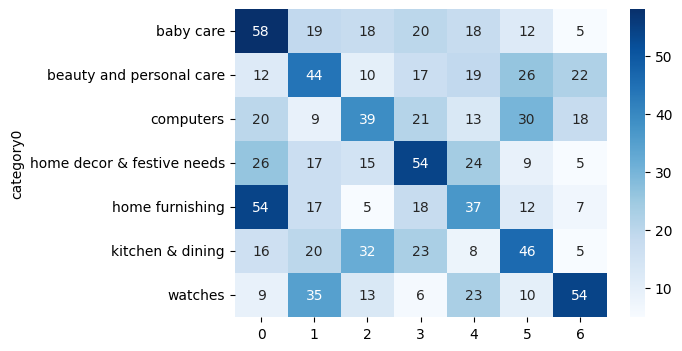

In [53]:
df_cm = pd.DataFrame(conf_mat, index = pd.crosstab(df["category0"], df["kmeans2_labels"]).reset_index()["category0"],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues")

On détermine assez bien à quels clusters les catégories de produits "baby care", "home decor & festive needs" et "watches" appartiennent.

Par contre pour les catégories "computers", "home furnishing" et "kitchen & dining", nous n'avons aucune certitude tant les valeurs maximales du nombre d'éléments associés aux clusters sont proches.

## Scores de classification

In [54]:
print(classification_report(df["category0"], df["category_pred"]))

                            precision    recall  f1-score   support

                 baby care       0.30      0.39      0.34       150
  beauty and personal care       0.27      0.29      0.28       150
                 computers       0.30      0.26      0.28       150
home decor & festive needs       0.34      0.36      0.35       150
           home furnishing       0.26      0.25      0.25       150
          kitchen & dining       0.32      0.31      0.31       150
                   watches       0.47      0.36      0.41       150

                  accuracy                           0.32      1050
                 macro avg       0.32      0.32      0.32      1050
              weighted avg       0.32      0.32      0.32      1050



On voit que les scores F1 les plus élevés correspondent aux catégories "watches", "home decor & festive needs" et "baby care". 
Ces scores restent néanmoins assez bas.

On voit que la sensibilité (capacité à detecter les éléments d'une classe définie) la plus faible correspond à la catégorie "home furnishing", suivie de la catégorie "kitchen & dining" et computers, ce qui expliquent les doutes exprimés avec la matrice de confusion.